# Mô tả bài toán
* Kernal bên dưới sử dụng structured-API để huấn luyện mô hình trên tập dữ liệu `Credit Card Fraud Detection` sử dụng Logistic Regression.
* Các phần chính của kernel bao gồm: khám phá dữ liệu, tiền xử lý cơ bản, huấn luyện mô hình và đánh giá.
* Đặc điểm lớn nhất của tập dữ liệu là vấn đề mất cân bằng trầm trọng giữa hai nhãn 0 và 1. Để giải quyết vấn đề này sẽ có ứng dụng kĩ thuật Undersampling để cải thiện chất lượng huấn luyện mô hình

# Chi tiết bài làm

### Import các thư viện cần thiết

In [1]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum, avg, count, when, round,rand

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import findspark
findspark.init()

### Khởi tạo session

In [3]:
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [ ]:
os.environ['SPARK_HOME']


'C:\\Users\\vietl\\Downloads\\spark-3.5.5-bin-hadoop3'

In [10]:
#os.environ['HADOOP_HOME'] 

In [4]:
spark = SparkSession.builder \
    .appName("Fraud_Dectection") \
    .getOrCreate()

In [5]:
datafolder="../../../dataset"

In [6]:
spark.conf.set("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000")


In [7]:
data = spark.read.csv('hdfs://localhost:9000/lab03/creditcard.csv', header=True, inferSchema=True)

Py4JJavaError: An error occurred while calling o28.csv.
: org.apache.hadoop.ipc.RpcException: RPC response has invalid length
	at org.apache.hadoop.ipc.Client$IpcStreams.readResponse(Client.java:1933)
	at org.apache.hadoop.ipc.Client$Connection.receiveRpcResponse(Client.java:1238)
	at org.apache.hadoop.ipc.Client$Connection.run(Client.java:1134)


### Khám phá dữ liệu

In [ ]:
data.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

In [ ]:
data.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [ ]:
data.count()

284807

In [ ]:
data.where(data['Class'] == 1).count()

492

In [ ]:
data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



Nhận xét sơ bộ: 
* Bộ dữ liệu bị lệch khi trong 284807 mẫu chỉ có 492 mẫu được ghi nhận là fraud.
* Bộ dữ liệu không tồn tại missing value.

### Tiền xử lý dữ liệu

Chuẩn hoá thuộc tính `time` và `amount`

In [ ]:
assembler = VectorAssembler(inputCols=["Time", "Amount"], outputCol="features_to_scale")
assembled_data = assembler.transform(data)

scaler = StandardScaler(inputCol="features_to_scale", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

scaled_data = scaled_data.withColumn("scaled_array", vector_to_array("scaled_features")) \
                         .withColumn("Time_scaled", col("scaled_array")[0]) \
                         .withColumn("Amount_scaled", col("scaled_array")[1])

cols_to_keep = [c for c in data.columns if c not in ["Time", "Amount"]]
final_data = scaled_data.select("Time_scaled", "Amount_scaled", *cols_to_keep)


In [ ]:
final_data.show(5)

+-------------------+--------------------+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+-----+
|        Time_scaled|       Amount_scaled|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19| 

Xoá dữ liệu trùng lặp

In [ ]:
print("Number of rows in data before drop duplicates: ", final_data.count())
final_data=final_data.drop_duplicates()
print("Number of rows in data after drop duplicates: ", final_data.count())

Number of rows in data before drop duplicates:  284807
Number of rows in data after drop duplicates:  283726


Do bộ dữ liệu bị thiên lệch lớn nên cần có sự phân chia phù hợp, đảm bảo có mặt tới tất cả bộ dữ liệu cho train và test

In [ ]:

final_data = final_data.sample(withReplacement=False, fraction=1.0, seed=42)

train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Kiểm tra phân bố của các lớp trong train và test
train_data.groupBy("Class").count().show()
test_data.groupBy("Class").count().show()

+-----+------+
|Class| count|
+-----+------+
|    1|   381|
|    0|226962|
+-----+------+

+-----+-----+
|Class|count|
+-----+-----+
|    1|   92|
|    0|56291|
+-----+-----+



Có thể thấy bộ dữ liệu đã giải quyết được vấn đề phân chia dữ liệu không công bằng giữa các tập dữ liệu, tiếp theo ta sẽ tiến hành huấn luyện mô hình

In [ ]:
training_cols= [c for c in train_data.columns if c not in ["Class"]]
assembler= VectorAssembler(inputCols=training_cols, outputCol="features")
assembled_train_data= assembler.transform(train_data).select("features", "Class")

In [ ]:
logistic_regression= LogisticRegression(featuresCol='features', labelCol='Class')
lg_model=logistic_regression.fit(assembled_train_data)

In [ ]:
def evaluate_training_model(model):
    summary = model.summary
    print("=== Train Evaluation ===")
    print("Coefficients:", model.coefficients)
    print("Intercept:", model.intercept)
    
    print("Accuracy:", summary.accuracy)
    print("AUC (ROC):", summary.areaUnderROC)
    print("Precision (class 0, 1):", summary.precisionByLabel)
    print("Recall (class 0, 1):", summary.recallByLabel)
    print("F1-score (class 0, 1):", summary.fMeasureByLabel())


In [ ]:
evaluate_training_model(lg_model)

=== Train Evaluation ===
Coefficients: [-0.17187092350616137,0.2321453524126453,0.09587500646599136,0.03536619716961149,-0.010602532748926353,0.7037378525505642,0.11890704919309614,-0.16504269044161007,-0.0672437227222587,-0.21676460224360092,-0.16966194324903805,-0.741152037101342,-0.055490325310463606,0.0627667359900915,-0.2609943196650208,-0.6105461022687548,-0.10330202046836008,-0.16933905785665715,-0.0504583329059169,-0.06051094589633126,0.07641005012546734,-0.41038081954284084,0.33247062352323375,0.5928428093287627,-0.06499570562919461,0.10587349961395658,-0.06277482709779408,0.08388153130138049,-0.9026945291492361,-0.39542574517298645]
Intercept: -8.635162891978922
Accuracy: 0.9991862516110018
AUC (ROC): 0.9766783834522602
Precision (class 0, 1): [0.9993306353239593, 0.8740458015267175]
Recall (class 0, 1): [0.9998546012107754, 0.6010498687664042]
F1-score (class 0, 1): [0.9995925496043326, 0.7122861586314152]


### Nhận xét: 
* Kết quả trên đang thể hiện kết quả khá tệ khi chỉ số mặc dù cao nhưng thiên hướng cao đối với nhãn 0 trong khi ít với nhãn 1 điều này là do dữ liệu mất cân bằng nặng.
* Recall (class 0, 1): Recall cho lớp 0 rất cao (0.9999), điều này có nghĩa là mô hình hầu như không bỏ sót trường hợp nào của lớp 0. Tuy nhiên, recall cho lớp 1 khá thấp (0.601), chỉ ra rằng mô hình có xu hướng bỏ sót nhiều trường hợp lớp 1.
* AUC (ROC): AUC = 0.977 là khá cao và chỉ ra rằng mô hình có khả năng phân biệt tốt giữa lớp 0 và lớp 1, ngay cả khi dữ liệu mất cân bằng.

### Kiểm tra trên tập test

In [ ]:
testing_cols= [c for c in test_data.columns if c not in ["Class"]]
assembler= VectorAssembler(inputCols=testing_cols, outputCol="features")
assembled_test_data= assembler.transform(test_data).select("features", "Class")
test_predictions= lg_model.transform(assembled_test_data).select("features", "Class", "prediction")

In [ ]:
test_predictions.show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
def test_evaluation(test_data):
    metrics_df = test_predictions.withColumn("tp", when((col("Class") == 1) & (col("prediction") == 1.0), 1).otherwise(0)) \
                             .withColumn("tn", when((col("Class") == 0) & (col("prediction") == 0.0), 1).otherwise(0)) \
                             .withColumn("fp", when((col("Class") == 0) & (col("prediction") == 1.0), 1).otherwise(0)) \
                             .withColumn("fn", when((col("Class") == 1) & (col("prediction") == 0.0), 1).otherwise(0))

   
    agg = metrics_df.selectExpr("sum(tp) as tp", "sum(tn) as tn", "sum(fp) as fp", "sum(fn) as fn").collect()[0]
    tp, tn, fp, fn = agg['tp'], agg['tn'], agg['fp'], agg['fn']

    
    # Lớp 1
    precision_1 = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall_1 = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) != 0 else 0
    support_1 = tp + fn

    # Lớp 0
    precision_0 = tn / (tn + fn) if (tn + fn) != 0 else 0
    recall_0 = tn / (tn + fp) if (tn + fp) != 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) != 0 else 0
    support_0 = tn + fp

    
    total = support_0 + support_1
    accuracy = (tp + tn) / total if total != 0 else 0

   
    print("              precision    recall  f1-score   support")
    print(f"           0    {precision_0:0.2f}      {recall_0:0.2f}      {f1_0:0.2f}       {support_0}")
    print(f"           1    {precision_1:0.2f}      {recall_1:0.2f}      {f1_1:0.2f}       {support_1}")
    print()
    print(f"    accuracy                        {accuracy:0.2f}       {total}")

In [ ]:
test_evaluation(test_predictions)

              precision    recall  f1-score   support
           0    1.00      1.00      1.00       56291
           1    0.86      0.66      0.75       92

    accuracy                        1.00       56383


### Nhận xét: 
* Kết quả trên cho thấy hiện tại mô hình đang đạt kết ở mức trung bình.
* Với vấn đề được đặt ra bởi bài toán là xác định giao dịch nào là lừa đảo, ta sẽ có mong muốn tập trung hơn vào việc xác định các giao dịch là lừa đảo thay vì không phải lừa đảo, tức là sẽ tập trung vào nhãn 1 đặc biệt là chỉ số recall.
* Bởi bộ dữ liệu trên bị mất cân bằng rất nặng nên có thể thấy các chỉ số dự đoán cho lớp 0 đạt kết quả rất lớn, trong khi chúng ta mong muốn dự đoán đúng lớp 1(là giao dịch lừa đảo) tốt hơn. Vậy nên cho dù dự đoán tất cả giao dịch là không lừa đảo thì vẫn đạt kết quả tốt.

### Phần tiếp theo ta sẽ cân nhắc áp dụng một số kĩ thuật để cải thiện chất lượng mô hình. Một số kĩ thuật sẽ được áp dụng bên dưới bao gồm: vẽ biểu đồ nhiệt xác định tương quan giữa các thuộc tính, loại bỏ các outlier.

### Biểu đồ tương quan

In [ ]:
final_data.show(5)

+-------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+-----+
|        Time_scaled|       Amount_scaled|                V1|                V2|                V3|               V4|                V5|                V6|                V7|                V8|                 V9|               V10|               V11|                V12|                V13|                V14|              V15|               V16|               V17|               V18|               V19|      

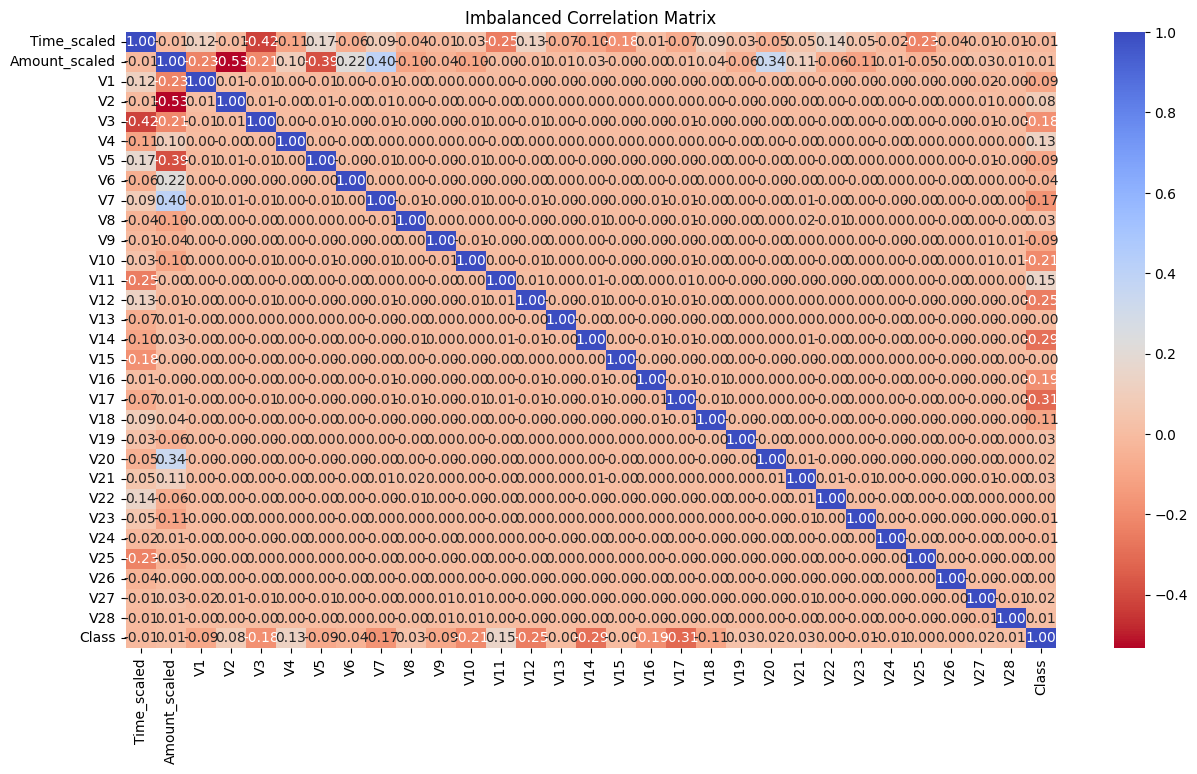

In [ ]:
cor_matrix = final_data.select([F.corr(c, 'Class') for c in final_data.columns if c != 'Class'])
pandas_test_predictions = final_data.toPandas()

corr_matrix = pandas_test_predictions.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm_r', fmt=".2f")
plt.title("Imbalanced Correlation Matrix")
plt.show()

Nhận xét: Hầu như rất khó phát hiện tương quan giữa các thuộc tính so với thuộc tính nhãn, hầu hết các thuộc tính có tương quan gần bằng 0. Không có thuộc tính nào nổi bật. Điều này có thể được giải thích bởi sự mất cân bằng nặng của dữ liệu, do đó thiếu lượng lớn mẫu để đánh giá tương quan. 

Lưu ý: Các tương quan nghịch càng đậm (nhiều đỏ) thì khi giá trị các thuộc tính này càng nhỏ thì khả năng giao dịch này là lừa đảo càng cao. Các tương quan dương càng đậm (càng xanh) thì khi giá trị các thuộc tính này càng lớn thì khả năng giao dịch lừa đảo là càng cao.

Với bộ dữ liệu trên ta chưa thể tiến hành xây dựng mô hình mà cần ít nhất phải xử lý vấn đề mất cân bằng dữ liệu bằng phương pháp làm phẳng dữ liệu. Có hai phương pháp phổ biến là undersampling và oversampling. Phần bên dưới sẽ chỉ áp dụng undersampling, tức là giảm dữ liệu nhãn có số lượng lớn hơn.

### Phân chia tập dữ liệu

In [ ]:
# Kết hợp dữ liệu lại sau khi shuffle
final_data = final_data.sample(withReplacement=False, fraction=1.0, seed=42)

# Chia dữ liệu với tỷ lệ 80-20
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Kiểm tra phân bố của các lớp trong train và test
train_data.groupBy("Class").count().show()
test_data.groupBy("Class").count().show()

+-----+------+
|Class| count|
+-----+------+
|    1|   381|
|    0|226962|
+-----+------+

+-----+-----+
|Class|count|
+-----+-----+
|    1|   92|
|    0|56291|
+-----+-----+



### Undersampling

In [ ]:
class_1 = train_data.filter(col('Class') == 1)
class_0 = train_data.filter(col('Class') == 0)

n_class_1 = class_1.count()
class_0_undersampled = class_0.orderBy(rand()).limit(n_class_1*80)
balanced_df = class_1.union(class_0_undersampled)


In [ ]:
balanced_df.where(balanced_df['Class'] == 1).count(),balanced_df.where(balanced_df['Class'] == 0).count()

(366, 30480)

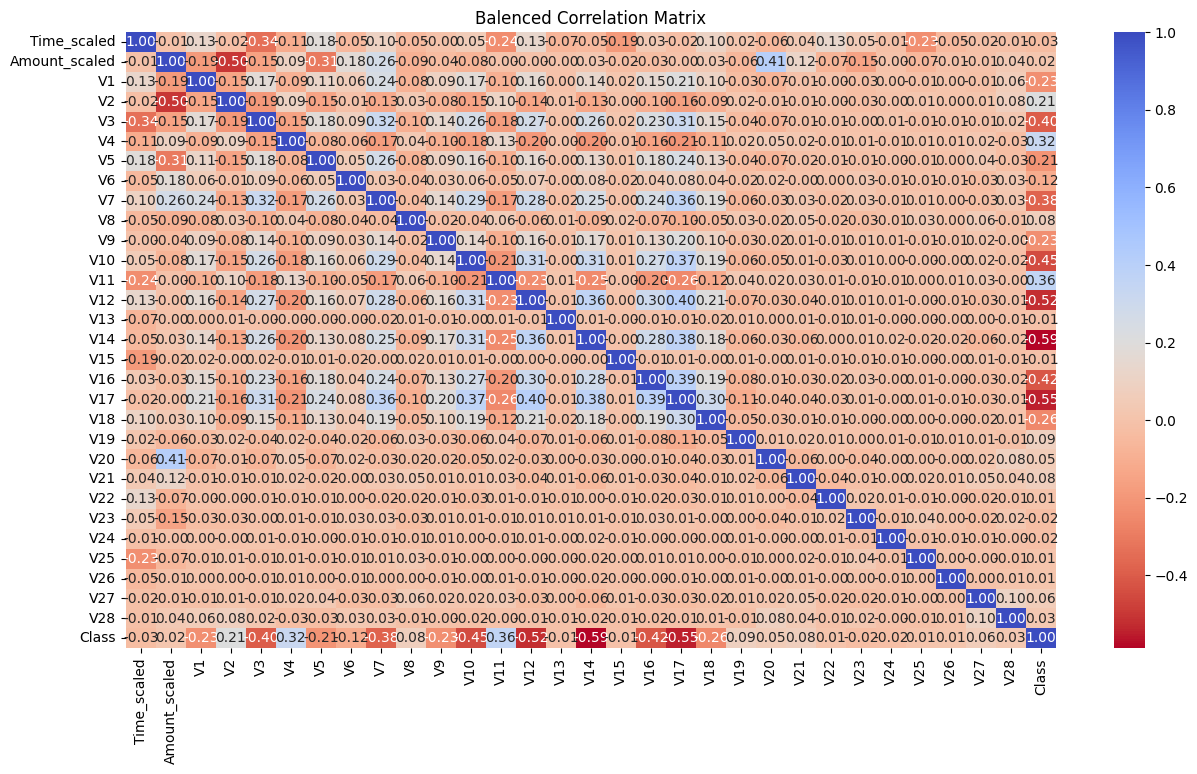

In [ ]:
cor_matrix = balanced_df.select([F.corr(c, 'Class') for c in balanced_df.columns if c != 'Class'])

pandas_df = balanced_df.toPandas()

corr_matrix = pandas_df.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm_r', fmt=".2f")
plt.title("Balenced Correlation Matrix")
plt.show()

Nhận xét:
* Ma trận tương quan khi undersamping cho thấy bộ dữ liệu có sự cải thiện đáng kể, tương quan giữa các thuộc tính trở nên rõ ràng hơn.
* Các thuộc tính có tương quan nghịch bao gồm: V14, V12, V10, V16, V17. Tức là các giá trị này các nhỏ thì khả năng là giao dịch lừa đảo càng cao
* Các thuộc tính có tương quan thuận bao gồm: V4, V11, V2, V19. Khi các giá trị này có giá trị càng cao thì khả năng lừa đảo là càng cao.


In [ ]:
training_balenced_cols= [c for c in balanced_df.columns if c not in ["Class"]]
assembler= VectorAssembler(inputCols=training_balenced_cols, outputCol="features")
assembled_train_balenced_data= assembler.transform(balanced_df).select("features", "Class")

In [ ]:
logistic_regression= LogisticRegression(featuresCol='features', labelCol='Class')
model=logistic_regression.fit(assembled_train_balenced_data)

In [ ]:
evaluate_training_model(model)

=== Train Evaluation ===
Coefficients: [-0.20527754686639102,0.2711062539973966,0.1347018711901001,0.046427097347037205,-0.022841897190439477,0.8348045628117924,0.10876430853524648,-0.3088097411506057,-0.012172856703163665,-0.28143705930297713,-0.09324625114620555,-0.6274920634329667,0.10312960247280951,-0.2682947784814512,-0.3241614922337311,-0.6442684034925338,-0.1523177456662906,-0.23587124494361417,-0.06741376575631436,-0.1434223788718659,0.041247813904436915,-0.3678338688103972,0.25458674068478626,0.4000574709787666,-0.03279538214445882,0.08162312043917562,-0.08794258228492205,-0.15859074793765426,-0.6404389743738187,-0.23472616680024413]
Intercept: -7.288117072783255
Accuracy: 0.997438889969526
AUC (ROC): 0.9839882463462558
Precision (class 0, 1): [0.9977405939945643, 0.9674267100977199]
Recall (class 0, 1): [0.9996719160104987, 0.8114754098360656]
F1-score (class 0, 1): [0.9987053212933676, 0.8826151560178305]


In [ ]:
testing_cols= [c for c in test_data.columns if c not in ["Class"]]
assembler= VectorAssembler(inputCols=testing_cols, outputCol="features")
assembled_test_data= assembler.transform(test_data).select("features", "Class")
test_predictions= model.transform(assembled_test_data).select("features", "Class", "prediction")

In [ ]:
test_evaluation(test_predictions)

              precision    recall  f1-score   support
           0    1.00      1.00      1.00       56291
           1    0.77      0.82      0.79       92

    accuracy                        1.00       56383


### Kết quả đã được cải thiện đáng kể, đặc biệt ở chỉ số recall của nhãn 1 điều này khá quan trọng khi ta sẽ muốn ghi nhận nhầm còn hơn bỏ sót các giao dịch được cho là lừa đảo.

### Lưu kết quả

In [ ]:

output_df = test_predictions.withColumn("features", col("features").cast("string"))

output_df.coalesce(1).write.parquet("Result/Predictions", mode="overwrite")
